2.4.1+cu124
12.4
True
0.5999999999999999
0.8047189562170504


C:\Users\Fish_Cat\AppData\Local\Temp\ipykernel_7544\2669967930.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(x)


[array(4.9935226, dtype=float32), array(4.84251, dtype=float32), array(4.946022, dtype=float32), array(4.796019, dtype=float32), array(4.661546, dtype=float32), array(4.6332216, dtype=float32), array(4.533713, dtype=float32), array(4.373182, dtype=float32), array(4.29807, dtype=float32), array(4.220798, dtype=float32), array(4.136437, dtype=float32), array(4.053194, dtype=float32), array(3.9427602, dtype=float32), array(3.9165196, dtype=float32), array(3.8893967, dtype=float32), array(3.7631779, dtype=float32), array(3.642912, dtype=float32), array(3.6170845, dtype=float32), array(3.5588982, dtype=float32), array(3.4599564, dtype=float32), array(3.4233804, dtype=float32), array(3.42576, dtype=float32), array(3.2733805, dtype=float32), array(3.2951431, dtype=float32), array(3.2720103, dtype=float32), array(3.1900048, dtype=float32), array(3.1804767, dtype=float32), array(3.0769985, dtype=float32), array(3.032567, dtype=float32), array(2.9651272, dtype=float32), array(2.936325, dtype=flo

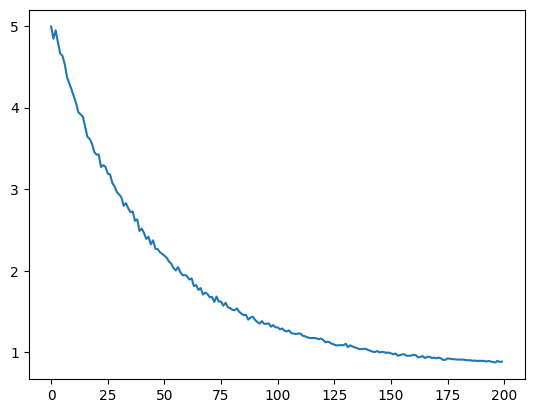

: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# 测试GPU环境是否可使用
print(torch.__version__) # pytorch版本
print(torch.version.cuda) # cuda版本
print(torch.cuda.is_available()) # 查看cuda是否可用

Numm = 1
Num = Numm * 2 #特征数量
Epoch = 200
N_samples = 10000
m = 1  # 质量
a = 1  # 时间步长
omega = 1  # 角频率

N = Num
mean2 = np.array(np.zeros(N))
Sigma_inv2 = np.zeros([N,N])
for i in range(N):
     for j in range(N):
        diff = abs(i-j)
        if diff==0:
            Sigma_inv2[i][j]=2/a+a
        elif diff==1 or diff==N-1:
            Sigma_inv2[i][j]=(-2/a)
#print(Sigma_inv2)
Sigma2 = np.linalg.inv(Sigma_inv2)
vec = np.linalg.eigvals(Sigma_inv2)
#samples2 = np.random.multivariate_normal(mean2, Sigma2, N_samples)
print(Sigma2[0, 0])
Z = -0.5*np.log(np.linalg.det(Sigma2))
print(Z)
#理论值
#loss收敛值
class flow_unit(nn.Module):
    def __init__(self,dim_channels) : 
        super().__init__() #继承

        #用于缩放
        self.scale = nn.Sequential( #模块包装
            nn.Linear(1, dim_channels),
            nn.ReLU(), #取正
            nn.Linear(dim_channels, dim_channels),#全连接层，实现线性变换
            nn.ReLU(),
            nn.Linear(dim_channels, 1),
            torch.nn.Tanh() #双曲正切（非线性变换
        )

        #用于平移
        self.trans = nn.Sequential(
            nn.Linear(1, dim_channels),
            nn.ReLU(),
            nn.Linear(dim_channels, dim_channels),
            nn.ReLU(),
            nn.Linear(dim_channels, 1),
            torch.nn.Tanh()

        )

    def forward(self, x, update_type):
        update = update_type % 2
        x_update = x[:, update::2].unsqueeze(1)
        x_used = x[:, (1 - update)::2].unsqueeze(1)
        
        scale = self.scale(x_used)
        trans = self.trans(x_used)
        x_update = x_update * torch.exp(scale) + trans


        y = torch.tensor(x)
        y[:,update::2] = x_update.squeeze(1)
        y[:,(1 - update)::2] = x_used.squeeze(1)
        log_det = -scale

        return y, log_det
# 创建流模型列表和优化器列表
flow_list = []
optim_list = []
#lrs_list = []
for i in range(30):  
    flow = flow_unit(dim_channels = 10)
    flow.cuda()
    optimizer = torch.optim.Adam(flow.parameters())
    flow_list.append(flow)
    optim_list.append(optimizer)    
    
 #   lrs = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Epoch)
 #   lrs_list.append(lrs)

loss_list= []
# 训练循环
for epoch in range(Epoch): #遍历每个训练周期，Epoch 是一个预先定义的整数，表示训练的总周期数
    samples0 = torch.randn(size=[N_samples , Num]).cuda()  #[样本数量，特征数量]<-生成随机样本
    log_det = 0 #对数行列式
    samples = samples0
    for i in range(Num):  
        samples, log_det0 =  flow_list[i](samples, i)
        log_det = log_det + log_det0

# 计算损失函数并更新模型参数...
    energy = m * (((samples - torch.roll(samples, -1, dims = 1)).pow(2)).sum(1)) / (2 * a) + a * m * (omega**2) * (samples * samples).sum(1) / 2
#上面时间步长怎么来的

# 计算损失函数
    loss = (-0.5 * (samples0 * samples0).sum(1) + log_det + energy).mean()


    for i in range(Num):
        optim_list[i].zero_grad()
    loss.backward() #计算损失函数相对于模型参数的梯度
    for i in range(Num):
        optim_list[i].step() #根据梯度和学习率等参数更新模型的参数
#        lrs_list[i].step()
        
    #optimizer.zero_grad()
    loss_list.append(loss.cpu().detach().numpy() )
    #loss.backward()
    #optimizer.step()
print(loss_list)
plt.plot(np.arange(np.array(loss_list).shape[0]),np.array(loss_list))
(samples*samples).mean()
print(samples)